<a href="https://colab.research.google.com/github/LindaSekhoasha/Axiom-Extraction-From-Text-Using-Deep-Learning/blob/main/Axioms_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup (Installs • Imports • Config)

In [1]:
%%capture
!pip -q install "transformers>=4.40" torch spacy datasets rdflib pandas --upgrade
!python -m spacy download en_core_web_sm

In [2]:
# standard library
import io
import gzip
import json
import os
import re
import shutil
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path
from typing import List, Tuple, Optional
from urllib.parse import quote

# third-party
import pandas as pd
import pydotplus
import spacy
import torch
import torch.nn.functional as F
from datasets import load_dataset
from google.colab import files
from IPython.display import display, Image
from rdflib import Graph, URIRef, Literal, Namespace, RDF, XSD
from rdflib import Graph as RDFGraph
from rdflib.namespace import OWL
from rdflib.tools.rdf2dot import rdf2dot
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    LukeTokenizer,
    LukeForEntityPairClassification,
)

## Helper Functions

In [3]:
_TAG = re.compile(r"<[^>]+>")
def _clean_local(s: str) -> str:
    s = _TAG.sub("", s).strip().replace(",", "")
    s = "_".join(s.split())
    s = re.sub(r"[^A-Za-z0-9_\-./:]", "", s)
    return s

def subject_uri_from_head(head: str):
    h = _clean_local(head)
    if not h:
        return None
    return _uri(DBR, h)

def _uri(ns: Namespace, local: str) -> URIRef:
    base = str(ns)
    local = _clean_local(local)
    return URIRef(base + quote(local, safe=":/._-"))

def add_triplets_to_luke_graph(triplets, g: Graph, cls_name: str):
    for h, r, t in triplets:
        head = _clean_local(h)
        pred = _clean_local(r)
        tail = t.strip()
        if not head or not pred:
            continue
        subj_uri = _uri(DBR, head)
        pred_uri = _uri(EX, pred)
        # simple literal/entity heuristic
        if tail.isdigit() and len(tail) == 4:
            obj_val = Literal(tail, datatype=XSD.gYear)
        elif tail.isdigit():
            obj_val = Literal(int(tail), datatype=XSD.integer)
        else:
            obj_val = _uri(DBR, tail)
        g.add((subj_uri, pred_uri, obj_val))
        g.add((subj_uri, RDF.type, DBO[cls_name]))

def add_triplets_to_rebel_graph(triplets, cls_label):
    """
    add extracted triplets to the RDF graph for a given dbpedia class.

    args:
        triplets (list of dict): [{'head': ..., 'type': ..., 'tail': ...}]
        cls_label (int): Index of the dbpedia class from DBPEDIA_CLASSES
    """
    cls_name = DBPEDIA_CLASSES[cls_label]
    g = graphs_rebel[cls_name]

    for t in triplets:
        head = _clean_local(t['head'])
        pred = _clean_local(t['type'])
        tail = t['tail'].strip()

        # skip if predicate vanished after cleaning
        if not pred or not head:
            continue

        subj_uri = _uri(DBR, head)
        pred_uri = _uri(EX, pred)

        # tail: try to distinguish year, number, or entity; clean if entity
        if tail.isdigit() and len(tail) == 4:
            obj_val = Literal(tail, datatype=XSD.gYear)
        elif tail.isdigit():
            obj_val = Literal(int(tail), datatype=XSD.integer)
        else:
            obj_val = _uri(DBR, tail)

        # add the triple
        g.add((subj_uri, pred_uri, obj_val))

        # assert rdf:type for the subject
        g.add((subj_uri, RDF.type, DBO[cls_name]))

# process the text from the rebel model and return the triplets
def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets

# prune candidate pairs
def candidate_pairs_for_ents(ents):
    """
    ents: List[(text, (s,e), label)]
    returns: List[(h_text, (hs,he), t_text, (ts,te))]
    """
    pairs = []
    for i, (ht, (hs,he), hl) in enumerate(ents):
        for j, (tt, (ts,te), tl) in enumerate(ents):
            if i == j:
                continue
            if ALLOWED_PAIRS and (hl, tl) not in ALLOWED_PAIRS:
                continue
            if MAX_CHAR_DISTANCE and abs(hs - ts) > MAX_CHAR_DISTANCE:
                continue
            pairs.append((ht, (hs,he), tt, (ts,te)))
    if MAX_PAIRS_PER_DOC and len(pairs) > MAX_PAIRS_PER_DOC:
        pairs = pairs[:MAX_PAIRS_PER_DOC]
    return pairs

# rdf graph visualization
def visualize(graphs, doc_subjects, k: int = 5):
    """
    build a subgraph containing ONLY triples whose subjects came from
    dbpedia rows [0..k-1], and render it as a PNG.
    """
    # collect target subject URIs for the first k rows
    targets = set()
    for gidx in range(min(k, len(texts))):
        targets |= doc_subjects.get(gidx, set())

    # build subgraph: include any triple whose subject is in targets
    sub = RDFGraph()
    sub.bind("ex", EX); sub.bind("dbr", DBR); sub.bind("dbo", DBO)

    for g in graphs.values():
        for s, p, o in g:
            if s in targets:
                sub.add((s, p, o))

    if len(sub) == 0:
        print(f"No triples found for the first {k} rows.")
        return

    stream = io.StringIO()
    rdf2dot(sub, stream)
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    display(Image(dg.create_png()))

def _is_uri(x): return isinstance(x, URIRef)
def _is_lit(x): return isinstance(x, Literal)

def compute_metrics_for_graph(g, cls_name, DBO):
    cls_uri = URIRef(str(DBO) + cls_name)

    # individuals: subjects that are typed as this class
    individuals = {s for s, p, o in g.triples((None, RDF.type, cls_uri))}

    # basic counts
    uniques_s = set()
    uniques_p = set()
    uniques_o = set()
    obj_triples = 0
    data_triples = 0

    for s, p, o in g:
        uniques_s.add(s); uniques_p.add(p); uniques_o.add(o)
        if _is_lit(o):
            data_triples += 1
        else:
            obj_triples += 1

    total_props = obj_triples + data_triples
    relationship_richness = (obj_triples / total_props) if total_props else 0.0
    attribute_richness   = (data_triples / max(len(individuals), 1)) if len(individuals) else 0.0

    # degrees over individuals (within this graph)
    out_deg = defaultdict(int)
    in_deg  = defaultdict(int)
    for s, p, o in g:
        if s in individuals:
            out_deg[s] += 1
        if o in individuals:
            in_deg[o] += 1
    if individuals:
        avg_degree = sum(out_deg[i] + in_deg[i] for i in individuals) / len(individuals)
    else:
        avg_degree = 0.0

    return {
        "class": cls_name,
        "triples": len(g),
        "individuals": len(individuals),
        "unique_subjects": len(uniques_s),
        "unique_predicates": len(uniques_p),
        "unique_objects": len(uniques_o),
        "object_triples": obj_triples,
        "data_triples": data_triples,
        "relationship_richness": relationship_richness,
        "attribute_richness": attribute_richness,
        "avg_degree_individuals": avg_degree,
    }

## CONFIG & Variables

In [4]:
LUKE_MODEL          = "studio-ousia/luke-large-finetuned-tacred"  # pretrained, non-LLM baseline
REBEL_MODEL         = "Babelscape/rebel-large"                    # pretrained, LLMs

CONF_THRESHOLD      = 0.50                    # accept a relation only if softmax prob >= this
MAX_DOCS            = 120_000                      # train[:N] (used subset of dbpedia_14 do to hardware limitations)
BATCH_SIZE          = 128                     # number of texts per loop (NER + inference per pair)
NUM_RETURNS         = 3
PRINT_EVERY         = 100
OUTPUT_DIR_LUKE     = "out_luke"
OUTPUT_DIR_REBEL    = "out_rebel"
SAVE_XML_CLASS      = "Company"               # set None to skip
VALID_NER_LABELS    = {"PERSON","ORG","GPE","PRODUCT","FAC","WORK_OF_ART"}
MAX_PAIRS_PER_DOC   = 30                      # cap pairs per doc for speed; set None for all
doc_subjects_luke   = {}  # global_doc_idx -> set of subject URIs added from that row
doc_subjects_rebel  = {}  # global_doc_idx -> set of subject URIs added from that row

ALLOWED_PAIRS = {
    ("PERSON","ORG"), ("ORG","PERSON"),
    ("PERSON","GPE"), ("GPE","PERSON"),
    ("ORG","ORG"), ("ORG","GPE"), ("GPE","ORG"),
}
MAX_CHAR_DISTANCE = 120     # skip far-apart mentions; set None to disable
PAIR_BATCH        = 128     # pairs per LUKE forward; tune 32–128 on A100

# DATASET: [dbpedia_14](https://huggingface.co/datasets/fancyzhx/dbpedia_14/viewer/dbpedia_14/train?views%5B%5D=train&row=5)
---
A supervised text-classification benchmark built from DBpedia article abstracts. Each sample is short text (title + abstract) with one of 14 ontology classes (e.g., Company, Person, Place). The Hugging Face variant `fancyzhx/dbpedia_14` mirrors the widely used setup from the literature: ~560k training docs and 70k test docs with label IDs and class names.

In [5]:
dataset = load_dataset("fancyzhx/dbpedia_14", split=f"train[:{MAX_DOCS}]")
texts = [ex["content"] for ex in dataset]
labels = [ex["label"] for ex in dataset]

DBPEDIA_CLASSES = dataset.features["label"].names
print(f"DBPEDIA_CLASSES (ONTOLOGIES):\n{DBPEDIA_CLASSES}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dbpedia_14/train-00000-of-00001.parquet:   0%|          | 0.00/106M [00:00<?, ?B/s]

dbpedia_14/test-00000-of-00001.parquet:   0%|          | 0.00/13.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/70000 [00:00<?, ? examples/s]

DBPEDIA_CLASSES (ONTOLOGIES):
['Company', 'EducationalInstitution', 'Artist', 'Athlete', 'OfficeHolder', 'MeanOfTransportation', 'Building', 'NaturalPlace', 'Village', 'Animal', 'Plant', 'Album', 'Film', 'WrittenWork']


In [6]:
# NAMESPACES
EX  = Namespace("http://example.org/ontology/")
DBR = Namespace("http://dbpedia.org/resource/")
DBO = Namespace("http://dbpedia.org/ontology/")

graphs_luke = {cls: Graph() for cls in DBPEDIA_CLASSES}
graphs_rebel = {cls: Graph() for cls in DBPEDIA_CLASSES}

In [7]:
# batched spaCy NER once for all texts - LUKE
nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","attribute_ruler"])
nlp.max_length = max(len(t) for t in texts) + 10

ents_by_doc = []  # List[List[ (ent_text, (start_char,end_char), ent_label) ]]
for doc in nlp.pipe(texts, batch_size=256, n_process=2):
    ents = [(e.text, (e.start_char, e.end_char), e.label_) for e in doc.ents if e.label_ in VALID_NER_LABELS]
    ents_by_doc.append(ents)

# LUKE (TACRED)
---

Implements an entity-aware relation extraction workflow using `LukeTokenizer` and `LukeForEntityPairClassification` from Hugging Face Transformers (Yamada et al., 2020 [[ACL Anthology]](https://aclanthology.org/2020.emnlp-main.523/)) and the TACRED schema (Zhang et al., 2017 [[ACL Anthology]](https://aclanthology.org/D17-1004/)).
It encodes character-span entity pairs directly (no offset remapping), tokenizes with `task="entity_pair_classification"`, and batches through LUKE on GPU with AMP acceleration.
Logits are softmax-normalized, mapped to `id2label`, and filtered by `conf_threshold` to discard low-confidence or `no_relation` predictions.
Each document's pre-detected NER entities (restricted to `valid_ner_labels`) are enumerated into head-tail candidate pairs, truncated by `MAX_PAIRS_PER_DOC`, then processed in mini-batches (`PAIR_BATCH`).
The resulting `(head, relation, tail)` triplets are aligned to source documents and inserted into per-class DBpedia graphs for ontology construction. This is in accordance with LUKE's entity-aware self-attention design (Yamada et al., 2020) and TACRED's labeled-relation benchmark protocol (Zhang et al., 2017).


In [8]:
@dataclass
class Triplet:
    head: str
    rel: str
    tail: str

class LukeExtractor:
    """
    class wrapper for LUKE TACRED relation classifier.
    uses character-based entity spans directly (no offset mapping).
    """
    def __init__(self, model_name=LUKE_MODEL, conf_threshold=CONF_THRESHOLD,
                 valid_ner_labels=VALID_NER_LABELS, device: Optional[str] = "cuda"):
        self.device = "cuda" if (device == "cuda" and torch.cuda.is_available()) else "cpu"
        self.tok = LukeTokenizer.from_pretrained(model_name, task="entity_pair_classification")
        self.model = LukeForEntityPairClassification.from_pretrained(model_name).to(self.device).eval()
        self.conf_threshold = conf_threshold
        self.valid_ner = set(valid_ner_labels)

    # vectorized forward for a batch of pairs
    def _classify_pairs_batch(self, texts_list, spans_list):
        """
        texts_list: List[str]
        spans_list: List[[ (hs,he), (ts,te) ]]
        returns: (pred_ids, confs)
        """
        inputs = self.tok(
            texts_list,
            entity_spans=spans_list,
            add_prefix_space=True,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=256,
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=(self.device=="cuda")):
            logits = self.model(**inputs).logits
        probs = torch.softmax(logits, dim=-1)
        confs, pred_ids = probs.max(dim=-1)
        return pred_ids.cpu().tolist(), confs.cpu().tolist()

    def _pairs(self, text: str) -> List[Tuple[str, Tuple[int,int], str, Tuple[int,int]]]:
        # produce candidate entity pairs and their character spans
        doc = self.ner(text)
        ents = [e for e in doc.ents if e.label_ in self.valid_ner]
        pairs = []
        for i, h in enumerate(ents):
            for j, t in enumerate(ents):
                if i == j:
                    continue
                pairs.append((h.text, (h.start_char, h.end_char), t.text, (t.start_char, t.end_char)))
        if MAX_PAIRS_PER_DOC and len(pairs) > MAX_PAIRS_PER_DOC:
            pairs = pairs[:MAX_PAIRS_PER_DOC]
        return pairs

    def extract_batch(self, texts: List[str], ents_slice: List[list]) -> List[List[Triplet]]:
        """
        ents_slice: precomputed entities for these texts (subset of ents_by_doc)
        returns: List[List[Triplet]] aligned to `texts`
        """
        results = [[] for _ in range(len(texts))]

        # flatten pairs across docs
        flat_texts, flat_spans, index_map, head_cache, tail_cache = [], [], [], [], []
        for di, ents in enumerate(ents_slice):
            pairs = candidate_pairs_for_ents(ents)
            for (h_txt,(h_s,h_e), t_txt,(t_s,t_e)) in pairs:
                flat_texts.append(texts[di])
                flat_spans.append([(h_s,h_e), (t_s,t_e)])
                index_map.append(di)
                head_cache.append(h_txt)
                tail_cache.append(t_txt)

        # run LUKE in mini-batches
        id2label = self.model.config.id2label
        for k in range(0, len(flat_texts), PAIR_BATCH):
            b_texts = flat_texts[k:k+PAIR_BATCH]
            b_spans = flat_spans[k:k+PAIR_BATCH]
            pred_ids, confs = self._classify_pairs_batch(b_texts, b_spans)
            for off, (pid, conf) in enumerate(zip(pred_ids, confs)):
                lbl = id2label[pid]
                if lbl != "no_relation" and conf >= self.conf_threshold:
                    di = index_map[k + off]
                    h_txt = head_cache[k + off]
                    t_txt = tail_cache[k + off]
                    results[di].append(Triplet(h_txt, lbl, t_txt))

        return results

## Luke model loop

In [9]:
os.makedirs(OUTPUT_DIR_LUKE, exist_ok=True)
# prepare graphs per class
for g in graphs_luke.values():
    g.bind("ex", EX); g.bind("dbr", DBR); g.bind("dbo", DBO)

extractor = LukeExtractor()

# process texts in batches
total = len(texts)
for i in range(0, total, BATCH_SIZE):
    batch_texts  = texts[i:i+BATCH_SIZE]
    batch_labels = labels[i:i+BATCH_SIZE]

    ents_slice = ents_by_doc[i:i+BATCH_SIZE]
    per_doc_trips = extractor.extract_batch(batch_texts, ents_slice)

    start = i  # batch start index in the global dataset

    for j, (trips, lbl) in enumerate(zip(per_doc_trips, batch_labels)):
        if not trips:
            continue
        cls_name = DBPEDIA_CLASSES[lbl]

        # record subjects for this global row index
        gidx = start + j

        subs = {subject_uri_from_head(t.head) for t in trips if _clean_local(t.head)}
        if subs:
            doc_subjects_luke[gidx] = subs

        # add to the class graph
        add_triplets_to_luke_graph([(t.head, t.rel, t.tail) for t in trips], graphs_luke[cls_name], cls_name)


    # progress ping
    done = i + len(batch_texts)
    batch_idx = i // BATCH_SIZE + 1
    if PRINT_EVERY and batch_idx % PRINT_EVERY == 0:
        print(f"Processed {batch_idx} batches ({done}/{total} docs)")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

entity_vocab.json:   0%|          | 0.00/15.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/33.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at studio-ousia/luke-large-finetuned-tacred were not used when initializing LukeForEntityPairClassification: ['luke.embeddings.position_ids']
- This IS expected if you are initializing LukeForEntityPairClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LukeForEntityPairClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipython-input-372488983.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(self.device=="cuda")):
1 entities are ignored because their entity spans are invalid due to the truncation o

Processed 100 batches (12800/120000 docs)


1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens


Processed 200 batches (25600/120000 docs)
Processed 300 batches (38400/120000 docs)


1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens


Processed 400 batches (51200/120000 docs)


1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens


Processed 500 batches (64000/120000 docs)


1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens


Processed 600 batches (76800/120000 docs)


1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens


Processed 700 batches (89600/120000 docs)
Processed 800 batches (102400/120000 docs)


1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens


Processed 900 batches (115200/120000 docs)


2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
1 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens
2 entities are ignored because their entity spans are invalid due to the truncation of input tokens


# REBEL
---
Uses a generative, BART-based relation extractor to produce linearized triples with special tokens `<triplet> <subj> <obj>` (REBEL) loaded via `AutoTokenizer`/`AutoModelForSeq2SeqLM`, then run with batched beam search (`num_beams=4`, `num_return_sequences=NUM_RETURNS`) and GPU if available (Google's A100 40GB for reproducibility); outputs are decoded and parsed into `(head, type, tail)` using a token-aware parser that follows the REBEL formatting scheme *(Cabot & Navigli, 2021; [Babelscape model card](https://github.com/babelscape/rebel)*).

**Post-processing + graph build:** For each document, generated triples are deduplicated per-doc (set-based on cleaned `(head, type, tail)`), subjects are normalized to DBpedia-style URIs (percent-safe, whitespace replaced with underscores), and predicates are cleaned to local names; tails are typed heuristically as `xsd:gYear`, integer literal, or DBpedia entity. Valid triples are inserted into the per-class RDF graphs (and subjects asserted with `rdf:type` to the class), while `doc_subjects_rebel` records the subject URIs for visualization and subgraph extraction *(REBEL decoding format and downstream triple materialization as per Cabot & Navigli, 2021)*.


In [10]:
# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(f"{REBEL_MODEL}")
model = AutoModelForSeq2SeqLM.from_pretrained(f"{REBEL_MODEL}")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.to(DEVICE)
model.eval()

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50272, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50272, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        

## Rebel model loop

In [11]:
for i in range(0, len(texts), BATCH_SIZE):
    batch_texts = texts[i:i + BATCH_SIZE]
    batch_labels = labels[i:i + BATCH_SIZE]

    # encode batch (pad) and move to device
    enc = tokenizer(batch_texts, max_length=256, truncation=True, padding=True, return_tensors="pt")
    enc = {k: v.to(DEVICE) for k, v in enc.items()}

    # generate
    outputs = model.generate(
        enc["input_ids"],
        attention_mask=enc["attention_mask"],
        max_length=512,
        num_beams=4,
        num_return_sequences=NUM_RETURNS
    )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=False)

    # group back into per-document lists of size NUM_RETURNS
    per_doc_decoded = [decoded[j:j + NUM_RETURNS] for j in range(0, len(decoded), NUM_RETURNS)]

    j = 0 # local row offset within this batch
    # for each document in the batch, parse, de-dup, then add to its class graph
    for decodes, lbl in zip(per_doc_decoded, batch_labels):
        triplets = []
        for d in decodes:
            triplets += extract_triplets(d)
        # per-doc de-dup (preserve original logic)
        seen = set(); uniq = []
        for t in triplets:
            key = (t['head'].strip(), t['type'].strip(), t['tail'].strip())
            if key not in seen:
                seen.add(key); uniq.append(t)
        if uniq:
            subs = set()
            for t in uniq:
                uri = subject_uri_from_head(t['head'])
                if uri is not None:
                    subs.add(uri)
            if subs:
                doc_subjects_rebel[i + j] = subs
            add_triplets_to_rebel_graph(uniq, lbl)
        j += 1
    # progress ping
    batch_idx = i // BATCH_SIZE + 1
    if batch_idx % PRINT_EVERY == 0:
        print(f"Processed {batch_idx} batches ({i + len(batch_texts)} docs)")

Processed 100 batches (12800 docs)
Processed 200 batches (25600 docs)
Processed 300 batches (38400 docs)
Processed 400 batches (51200 docs)
Processed 500 batches (64000 docs)
Processed 600 batches (76800 docs)
Processed 700 batches (89600 docs)
Processed 800 batches (102400 docs)
Processed 900 batches (115200 docs)


# METRICS
Compute OntoQA-inspired stats for each class and the merged graph (for LUKE and REBEL); outputs per-class CSV + console summary (triples, unique subjects/predicates/objects).

In [12]:
# save each luke ontology graph
for cls, g in graphs_luke.items():
    g.serialize(f"Luke_{cls}.ttl", format="turtle")
    print(f"Saved ontology for {cls}, {len(g)} triples")

Saved ontology for Company, 179906 triples
Saved ontology for EducationalInstitution, 233429 triples
Saved ontology for Artist, 103007 triples
Saved ontology for Athlete, 0 triples
Saved ontology for OfficeHolder, 0 triples
Saved ontology for MeanOfTransportation, 0 triples
Saved ontology for Building, 0 triples
Saved ontology for NaturalPlace, 0 triples
Saved ontology for Village, 0 triples
Saved ontology for Animal, 0 triples
Saved ontology for Plant, 0 triples
Saved ontology for Album, 0 triples
Saved ontology for Film, 0 triples
Saved ontology for WrittenWork, 0 triples


In [13]:
# save each rebel ontology graph
for cls, g in graphs_rebel.items():
    g.serialize(f"Rebel{cls}.ttl", format="turtle")
    print(f"Saved ontology for {cls}, {len(g)} triples")

Saved ontology for Company, 235055 triples
Saved ontology for EducationalInstitution, 242626 triples
Saved ontology for Artist, 253764 triples
Saved ontology for Athlete, 0 triples
Saved ontology for OfficeHolder, 0 triples
Saved ontology for MeanOfTransportation, 0 triples
Saved ontology for Building, 0 triples
Saved ontology for NaturalPlace, 0 triples
Saved ontology for Village, 0 triples
Saved ontology for Animal, 0 triples
Saved ontology for Plant, 0 triples
Saved ontology for Album, 0 triples
Saved ontology for Film, 0 triples
Saved ontology for WrittenWork, 0 triples


## LUKE

In [14]:
# per-class metrics
rows = []
for cls_name, g in graphs_luke.items():
    if len(g) == 0:
        continue
    rows.append(compute_metrics_for_graph(g, cls_name, DBO))

metrics_df = pd.DataFrame(rows).sort_values("triples", ascending=False)
display(metrics_df)

# save CSV for record
metrics_luke = "luke_ontology_metrics_per_class.csv"
metrics_df.to_csv(f"{metrics_luke}")
print(f"Saved: {metrics_luke}")

# merged/global view
G_all = RDFGraph()
for g in graphs_luke.values():
    G_all += g

global_stats = {
    "triples": len(G_all),
    "unique_subjects": len({s for s,_,_ in G_all}),
    "unique_predicates": len({p for _,p,_ in G_all}),
    "unique_objects": len({o for _,_,o in G_all}),
}
print("Global graph summary:", global_stats)

# save the global summary next to the CSV
with open(os.path.join(OUTPUT_DIR_LUKE, "global_summary.json"), "w") as f:
    import json
    json.dump(global_stats, f, indent=2)

,class,triples,individuals,unique_subjects,unique_predicates,unique_objects,object_triples,data_triples,relationship_richness,attribute_richness,avg_degree_individuals
1,EducationalInstitution,233429,69573,69573,31,61197,233429,0,1.0,0.0,5.466589
0,Company,179906,59599,59599,34,51043,179906,0,1.0,0.0,4.848504
2,Artist,103007,37719,37719,37,27346,103007,0,1.0,0.0,4.082743


Saved: luke_ontology_metrics_per_class.csv
Global graph summary: {'triples': 515179, 'unique_subjects': 160329, 'unique_predicates': 39, 'unique_objects': 131340}


## REBEL

In [15]:
# per-class metrics
rows = []
for cls_name, g in graphs_rebel.items():
    if len(g) == 0:
        continue
    rows.append(compute_metrics_for_graph(g, cls_name, DBO))

metrics_df = pd.DataFrame(rows).sort_values("triples", ascending=False)
display(metrics_df)

# save CSV for record
metrics_rebel = "rebel_ontology_metrics_per_class.csv"
metrics_df.to_csv(f"{metrics_rebel}", index=False)
print(f"Saved: {metrics_rebel}")

# merged/global view
G_all = Graph()
for g in graphs_rebel.values():
    G_all += g

global_stats = {
    "triples": len(G_all),
    "unique_subjects": len({s for s,_,_ in G_all}),
    "unique_predicates": len({p for _,p,_ in G_all}),
    "unique_objects": len({o for _,_,o in G_all}),
}
print("Global graph summary:", global_stats)

,class,triples,individuals,unique_subjects,unique_predicates,unique_objects,object_triples,data_triples,relationship_richness,attribute_richness,avg_degree_individuals
2,Artist,253764,78693,78693,215,71888,241357,12407,0.951108,0.157663,4.520542
1,EducationalInstitution,242626,73138,73138,195,30796,229107,13519,0.944280,0.184842,5.216946
0,Company,235055,75946,75946,242,41064,216814,18241,0.922397,0.240184,4.603705


Saved: rebel_ontology_metrics_per_class.csv
Global graph summary: {'triples': 721513, 'unique_subjects': 217661, 'unique_predicates': 282, 'unique_objects': 131526}


# VISUALIZATION
Sample a small k-elements graph to visualize the axioms (and relations) automated.

## LUKE

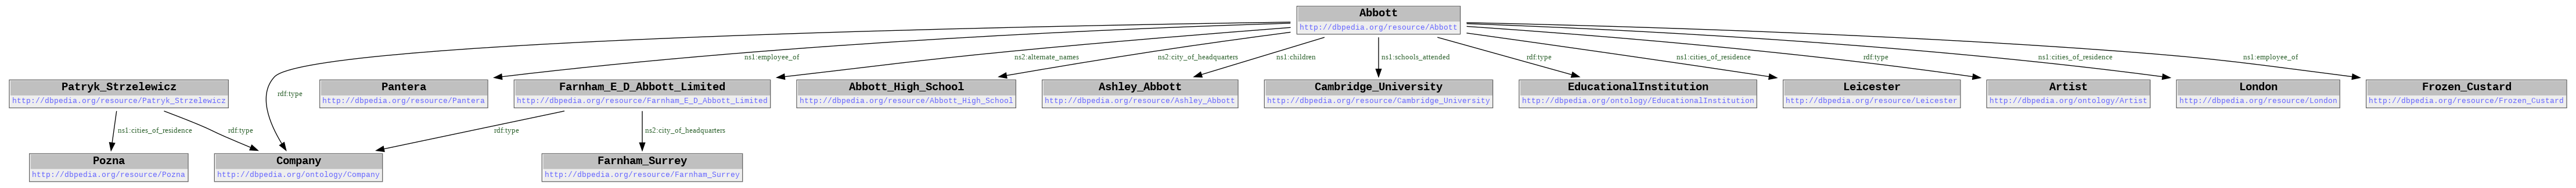

In [16]:
# visualize a subgraph of ontology graph for luke_model
visualize(graphs_luke, doc_subjects_luke, k=3)

## REBEL

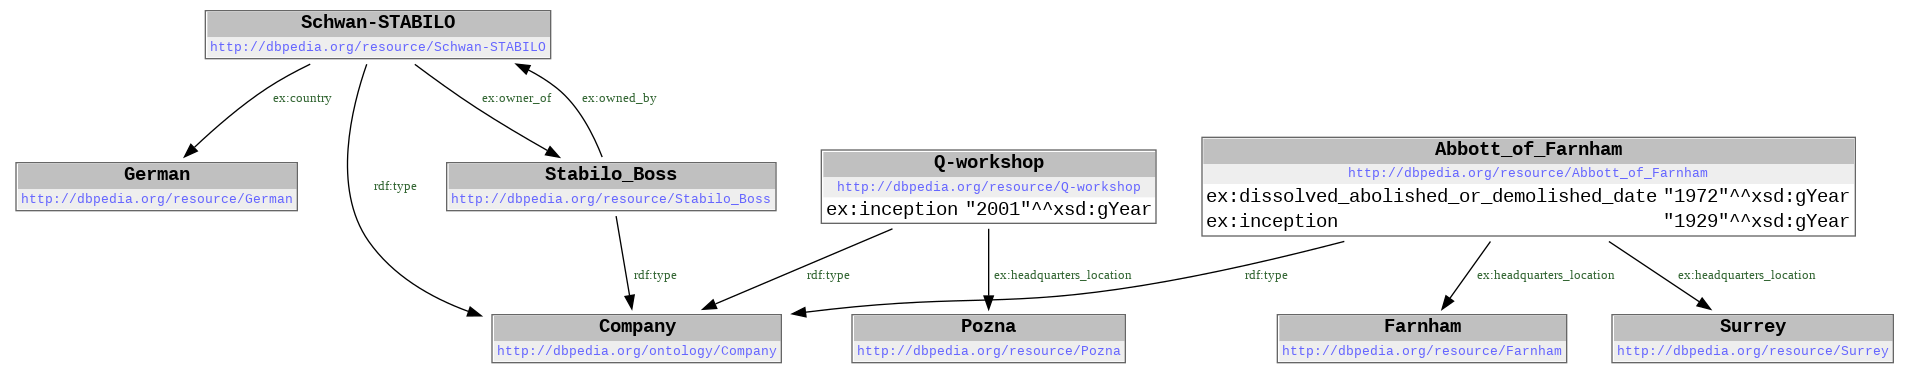

In [17]:
# visualize a subgraph of ontology graph for rebel_model
visualize(graphs_rebel, doc_subjects_rebel, k=3)

# ONTOLOGIES
This section automates the exporting, organizing, and packaging of RDF/OWL ontologies generated by the LUKE and REBEL models.
The output OWL files are to be further analysed for ROBOT metrics.

In [18]:
Path(OUTPUT_DIR_LUKE).mkdir(parents=True, exist_ok=True)
Path(OUTPUT_DIR_REBEL).mkdir(parents=True, exist_ok=True)

In [19]:
def save_merged_owl(graphs_dict, out_path, iri: str):
    G = Graph()
    for g in graphs_dict.values():
        if len(g):
            G += g
    if len(G) == 0:
        return
    ont_iri = URIRef(iri)
    G.add((ont_iri, RDF.type, OWL.Ontology))
    G.serialize(out_path, format="pretty-xml")  # RDF/XML as .owl

In [20]:
save_merged_owl(graphs_luke,  Path(OUTPUT_DIR_LUKE)  / "luke_ontology.owl",  "http://example.org/ontology/luke")
save_merged_owl(graphs_rebel, Path(OUTPUT_DIR_REBEL) / "rebel_ontology.owl", "http://example.org/ontology/rebel")

In [21]:
def save_per_class_owl(graphs_dict, out_dir: Path, prefix: str, gzip_it: bool = True):
    for cls, g in graphs_dict.items():
        if len(g) == 0:
            continue
        out_path = out_dir / f"{prefix}_{cls}.owl"
        if gzip_it:
            with gzip.open(str(out_path) + ".gz", "wb") as f:
                data = g.serialize(format="pretty-xml")  # RDF/XML
                f.write(data if isinstance(data, bytes) else data.encode("utf-8"))
        else:
            g.serialize(out_path, format="pretty-xml")

# Luke per-class OWL
save_per_class_owl(graphs_luke, Path(OUTPUT_DIR_LUKE), "Luke", gzip_it=True)
# Rebel per-class OWL
save_per_class_owl(graphs_rebel, Path(OUTPUT_DIR_REBEL), "Rebel", gzip_it=True)

In [22]:
# paths
out_luke  = Path(OUTPUT_DIR_LUKE)
out_rebel = Path(OUTPUT_DIR_REBEL)

# make zips
zip_luke  = shutil.make_archive('/content/luke_ontologies',  'zip', out_luke)
zip_rebel = shutil.make_archive('/content/rebel_ontologies', 'zip', out_rebel)

# download
files.download(zip_luke)
files.download(zip_rebel)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>